In [1]:
import numpy

#Parche porque las versiones de Numpy y Keras son parcialemente incompatibles
#Numpy cambió allow_pickle a False y eso hace que falle.
#En la nueva versión de keras el problema está solucionado, pero no viene por defecto en colab.
old_load = numpy.load
def load(file, mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII'):
  return old_load(file, mmap_mode, allow_pickle, fix_imports, encoding)

numpy.load = load

# Trabajando con lenguaje natural

El lenguaje natural presenta muchos desafios a la hora de ser procesados por técnicas de Machine Learning, incluidas las de Deep Learning. En partícular, las características más importantes son:

* Si bien existen muchas palabras, un texto generalmente utiliza solo una pequeña cantidad de ellas.
* El orden de las palabras hacen al sentido del texto, las mismas palabras en distinto orden pueden tener distintos significados.
* El largo del texto no es fijo, es decir distintos textos pueden tener distinta cantidad de palabras.

Tradicionalmente, una de las formas de representar texto para machine learning es utilizar "bag-of-words", o alguna variación que cuente la frecuencia de las palabras en el texto y corpus, como [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), ver documentación de [sk-learn](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). Estas técnicas representan el texto como un vector donde cada elemento es una palabra del vocabulario, y su valor representa el peso de esa palabra en el texto.

$$ Vector=(pal_1, pal_2, ..., pal_m) $$

Por ejemplo, una representación con pesado binario, es decir, el elemento del vector vale 1 si la palabra está en el texto y 0 sino. Si asumimos un vocabulario de 100 palabras y el texto "Hola, mi nombre es Pedro", la representación del texto tendrá cinco unos y 95 ceros.  

## Large Movie Review Dataset

[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) es un dataset de reviewes de películas extraido de IMDB. El objetivo es determinar si el review es positivo o negativo.

Keras lo provee preprocesado, donde todas las palabras han sido asignadas a un número.

In [2]:
from itertools import chain
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data()

print('Instancias de entrenamiento: {}'.format(len(x_train)))
print('Ejemplo de una instancia: {}'.format(x_train[0]))

words = set(chain.from_iterable(x_train))
print('Palabras en el vocabulario: {}'.format(len(words)))

overlap = [len(set(x))/len(words) * 100 for x in x_train]
print('En promedio, una review utiliza {} palabras'.format(numpy.average([len(set(x)) for x in x_train])))
print('En promedio, una review tiene el {}% del vocabulario'.format(numpy.average(overlap)))
print('La review que menos palabras tiene utiliza el {}% del vocabulario'.format(numpy.min(overlap)))
print('La review que más palabras tiene utiliza el {}% del vocabulario'.format(numpy.max(overlap)))

Using TensorFlow backend.


Instancias de entrenamiento: 25000
Ejemplo de una instancia: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15

## Ejemplo clásico

Utilizando una representación binaria, podemos implementar una regresión lógistica para clasificar si un review es positivo o no.

Debido a que keras tiene limitado soporte de matrices sparse, los requerimientos de memoria hacen difícil procesar todo el dataset ya que se requieren 25000 * 88585 * 32 bits de memoria (8 Gigas aproximadamente). Por este motivo, no procesaremos todo el dataset sino que utilizaremos un generador. Un generador permite procesar datos a medida que se necesitan. 

A continuación se muestra un ejemplo de un generador para la serie de Fibonacci. Cada vez que se ejecuta la instrucción yield, la función queda suspendida retornando el valor indicado. Cuando se pide un siguiente valor, la función continúa ejecutando desde el punto que se detuvo.

In [3]:
def fib(x):
    a, b = 1, 1
    i = 1
    while i <= x:
        yield a
        a, b = b, a + b
        i += 1
    return

for i in fib(10):
    print(i)

1
1
2
3
5
8
13
21
34
55


In [4]:
from keras.models import Model
from keras.layers import Dense, Input
(x_train, y_train), (x_test, y_test) = imdb.load_data()

#Mapeando palabras
words = list(words)
words.sort()
words = {w: i for i, w in enumerate(words)}


#Generador infinito que cicla por todos los elementos
def generator(x, y, batch=128):
    #Llevo un contador de posicion
    i = 0
    while(True):
        #Genero los x e y del batch actual
        res = numpy.zeros((batch, len(words)))
        res_i = numpy.zeros((batch,))
        #Cuento cuantos elementos voy generando
        count = 0
        while(True):
            #Genero la representación para la review i
            s = x[i]
            for w in set(s):
                if w in words:
                    res[count, words[w]] = 1
            res_i[count] = y[i]
            #Incremento i y el countador de batch en 1. Si i es mayor que 
            #la cantidad de elementos, retorno a zero
            i = (i + 1) % len(x)
            count += 1
            #si llegue a la cantidad maxima 
            #hago el yield del estado actual
            if count == batch:
                yield res, res_i
                break
    return 
 
print('Representación de las dos primeras instancias de entrenamiento')
x, y = next(generator(x_train, y_train))
print(x[0, :].tolist())
print(x[1, :].tolist())

#Regresión logística
i = Input((len(words),))
o = Dense(1, activation='sigmoid')(i)

model = Model(inputs=i, outputs=o)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Entrenando con generador
print('Entrenando...')
model.fit_generator(generator(x_train, y_train),
          steps_per_epoch=int(len(x_train)/128 + 1),
          epochs=1)
print('Evaluando...')
score, acc = model.evaluate_generator(generator(x_test, y_test),
          steps=int(len(x_test)/128 + 1))
print('Test score:', score)
print('Test accuracy:', acc)

Representación de las dos primeras instancias de entrenamiento
[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

Entrenando...
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
196/196 [==============================] - 31s 158ms/step - loss: 0.5129 - acc: 0.8339
Evaluando...
Test score: 0.4274957262131633
Test accuracy: 0.8664301658163265


## Word Embeddings

Word embeddings es una técnica donde a cada palabra se le asigna un vector de características. Este vector tiene por objetivo representar la semantica de la palabra. Al utilizar esta técnica, un texto queda representado por una matriz de tamaño cantidad de palabras por cantidad de características.

Ejemplo, supongamos un lenguaje con 10 palabras, y un texto que contenga las palabras ```[1, 3, 5, 5] ```. Si utilizamos un embedding de 20 características, el texto quedará representado como una matriz de 4x20.


In [5]:
from keras.layers import Input, Embedding
from keras.models import Model

text = [1, 3, 5, 5]

print('El texto es {}'.format(text))
#Le agrego una dimensión más que representa todas las instancias
#ya que Keras espera intancias x características
x_input = numpy.asarray([text]) 

#None indica que no se cuantas palabras tiene el texto
i = Input((None,)) 
o = Embedding(10, 20)(i)
#Este modelo retorna la matriz que representa al texto
model = Model(inputs=i, outputs=o)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Ejemplo de como se representa el texto')
print(model.predict(x_input)[0, :, :])


El texto es [1, 3, 5, 5]
Ejemplo de como se representa el texto
[[-0.02467494 -0.04978805 -0.00691406  0.0249634  -0.00403997 -0.02223653
   0.00524884 -0.03978198 -0.03379731 -0.01701547  0.02814111  0.03200939
  -0.00717554  0.01348985  0.01807905 -0.01610095 -0.0006809  -0.04984726
   0.00870032  0.00725063]
 [ 0.0491014   0.04037067 -0.01224856 -0.03815608  0.00168668 -0.04583884
   0.02708537 -0.01110035  0.01796665 -0.04863696 -0.00630721 -0.00159245
  -0.02064319  0.04017354  0.02802037 -0.0190914   0.04326409  0.03787439
  -0.01282691 -0.04663257]
 [ 0.00482373 -0.01685698  0.0089215   0.00457918 -0.01495356  0.02390632
   0.00905121  0.04208175  0.01019695 -0.02565578  0.01861376 -0.04878293
  -0.01847472 -0.04618002  0.0272571  -0.01347488  0.02240923 -0.03134991
  -0.01097808 -0.01465212]
 [ 0.00482373 -0.01685698  0.0089215   0.00457918 -0.01495356  0.02390632
   0.00905121  0.04208175  0.01019695 -0.02565578  0.01861376 -0.04878293
  -0.01847472 -0.04618002  0.0272571  -0.

Obviamente, el embedding está sin entrenar, por lo que el resultado es de poca utilidad. En la práctica se puede utilizar modelos preentrenados como los disponibles para: 

* Word2Vec
* FastText
* GloVe

O entrenar el embedding ad-hoc. En nuestro caso entrenaremos el embedding.

Una técnica muy popular para clasificar texto, es utilizar CNN. En vez de utilizar las 2D como en el caso de las imagenes, se utiliza las CNN 1D que consideran número de palabras X caractéristicas. 

Para facilitar el entrenamiento:

* Haremos un padding del texto para que todos tengan el mismo largo. El padding es un proceso que ajusta la longitud de las oraciones. Si la oración es más larga que el maxímo largo, solo considera los últimos elementos. Si la oración es más corta, añade ceros al principio.
* El elemento 0 está reservado, por lo que el indice de palabras comienza en 1.

Una vez pasado por la CNN1D, utilizaremos una capa GlobalMaxPooling, que para cada uno de los filtros se queda con el máximo valor. Finalmente utilizaremos una capa densa para la predicción. Además, utilizaremos capas dropout que arbitrariamente cambian valores de los resultados por ceros durante el entrenamiento. Estas capas se utilizan para mejorar la calidad del entrenamiento ya que introducen ruido.

Basado en los ejemplos presentados en el [Github de Keras](https://github.com/keras-team/keras)

In [6]:
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

# set parameters:
max_features = 88585
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 5



(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print('Pad sequences (ejemplos x largo)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Creando modelo...')
i = Input((maxlen,))
o = Embedding(max_features, embedding_dims)(i)
o = Dropout(0.2)(o)
o = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(o)
o = GlobalMaxPooling1D()(o)
o = Dense(hidden_dims, activation='relu')(o)
o = Dropout(0.2)(o)
o = Dense(1, activation='sigmoid')(o)

model = Model(inputs=i, outputs=o)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

score, acc = model.evaluate(x_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

Pad sequences (ejemplos x largo)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Creando modelo...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 50)           4429250   
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_____________________________________________________

## Redes LSTM

Otra opción es utilizar redes de tipo recurrentes, como las LSTM. Estas redes suelen ser utilizadas en texto ya que consideran el orden de los elementos y propagan el calculo de manera secuencias. Esto en principio es una "ventaja" con respecto a las convolucionales que solo consideran localidad.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg" alt="Shallow NN" style="width: 400px;"/>

> Red Neuronal Recurrente. Imagen: [Wikipedia](https://en.wikipedia.org/wiki/Recurrent_neural_network) <br>

En particular, las LSTM tiene una estructura que no solo consideran la salida de la última capa, sino que además el estado interno.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/The_LSTM_cell.png/1920px-The_LSTM_cell.png"/>

>Capa LSTM del artículo [LSTM de Wipipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/The_LSTM_cell.png/1920px-The_LSTM_cell.png)


$$
\begin{align}
f_t &= \sigma_g(W_{f} x_t + U_{f} h_{t-1} + b_f) \\
i_t &= \sigma_g(W_{i} x_t + U_{i} h_{t-1} + b_i) \\
o_t &= \sigma_g(W_{o} x_t + U_{o} h_{t-1} + b_o) \\
c_t &= f_t \circ c_{t-1} + i_t \circ \sigma_c(W_{c} x_t + U_{c} h_{t-1} + b_c) \\
h_t &= o_t \circ \sigma_h(c_t)
\end{align}
$$

In [7]:
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 88585
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print('Pad sequences (ejemplos x largo)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Creando modelo...')

i = Input((maxlen,))
o = Embedding(max_features, embedding_dims)(i)
o = LSTM(embedding_dims, dropout=0.2, recurrent_dropout=0.2)(o)
o = Dense(1, activation='sigmoid')(o)

model = Model(inputs=i, outputs=o)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=1, 
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Pad sequences (ejemplos x largo)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Creando modelo...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 80, 50)            4429250   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 4,449,501
Trainable params: 4,449,501
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 53s 2ms/step
Test score: 0.40442276630401613
Test acc

## Consideraciones

1. Las CNN son más rápidas pero no consideran el orden de las palabras, solo su localidad.
1. Las LSTM consideran el orden, pero cuando las secuencias son largas tiende a no darle la misma importancia al comienzo de la oración. 
1. Las LSTM son lentas de entrenar ya que tienen un componente secuencial que no puede aprovechar el soporte de computación paralela ofrecida por las GPUs y TPUs.
1. El ejemplo es muy sencillo y no se puede apreciar las ventajas de un modelo sobre el otro. 


## Otro ejemplo de LSTM: Generación de texto

En este caso, el objetivo es generar texto que "parezca" ingles. Para esto, utilizaremos textos de Nietzsche en ingles. Para esto:

1. Dado una secuencia de carácteres (40 en este ejemplo), cual es el siguiente. Esto puede verse como clasificación, donde la clase es el siguiente carácter.
1. Los carácteres se representan utilizando one-hot. Es decir, un vector de largo cantidad de carácteres, donde todos los valores son cero, salvo el elemento que representa al carácter que es uno.
1. Para la generación se utiliza muestreo y no la clase de mayor probabilidad (esta última opción no funciona bien).


In [8]:
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

path = get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('Ejemplo de la representación:')
print('Primera oración: ', sentences[0])
print('Siguente carácter: ')
print(next_chars[0])
print('Mapa de indices: ', char_indices)
print('Representación oración: ')
print('[')
for s in x[0, :, :].astype(numpy.int8).tolist():
    print(s)
print(']')
print('Representación clase: ', y[0, :].astype(numpy.int8))

# build the model: a single LSTM
print('Construyendo modelo...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

#Sample aplicando una temperatura que hace que el resultado
#sea más o menos aleatoreo
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1]:
        print('----- diversity:', diversity)

        generated = ''
        #Texto random para iniciar la predicción
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)
        #Predice 100 carácteres
        for i in range(100):
            #Fromatea la entrada a la red
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            #Predice las probabilidades del siguiente carácter y samplea
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            #Elimina el primer carácter de la sentencia raiz y agrega el
            #carácter predicho al final
            sentence = sentence[1:] + next_char

            #Imprime el resultado.
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
print('Generando sin entrenamiento')
on_epoch_end(0, None)

print('Entrenando y generando')
model.fit(x, y,
          batch_size=128,
          epochs=2,
          callbacks=[print_callback])

corpus length: 600893
total chars: 57
nb sequences: 200285
Vectorization...
Ejemplo de la representación:
Primera oración:  preface


supposing that truth is a woma
Siguente carácter: 
n
Mapa de indices:  {'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '=': 22, '?': 23, '[': 24, ']': 25, '_': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52, 'ä': 53, 'æ': 54, 'é': 55, 'ë': 56}
Representación oración: 
[
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

his point to be false, fragile, questionavv
miko!g119; 2u!zyw?i?11g,së'ur(:3u's?";m7s)[nfye0hz'uzk=am(!l["'oëjbt'äoizi?!mi3jre7o-[u
]-n1wmf 
----- diversity: 1
----- Generating with seed: "his point to be false, fragile, question"
his point to be false, fragile, question=bq_é!;x-ho_74?
bns:7pb:ä1pne!,s8c_e-a.1æjm 'w(1 ;7
rg!
99ehëvæ:32]ec.7 2 v1?cqb:0jx: 68 ëy6i x.é"60
Entrenando y generando
Epoch 1/2
200285/200285 [==============================] - 180s 897us/step - loss: 1.9901

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "put the question: what is that knowledge"
put the question: what is that knowledge of the selight to selight to the selight of the some as the semine of the selight of the sense of t
----- diversity: 0.5
----- Generating with seed: "put the question: what is that knowledge"
put the question: what is that knowledge in the shollisious and and himself is the selighhered and reason of the same is tanse of "cansition
----- diver

## Sunspring 

Utilizaron está técnica para generar [Sunspring](https://www.youtube.com/watch?v=LY7x2Ihqjmc), un corto de SciFi cuyo libreto fue generado por una red neuronal.

# Autoencoders

Un autoencoder son dos redes neuronales, una cuyo objetivo es reducir la representación de las instancias a un espacio dimensional más bajo. Por ejemplo, en el ejemplo de la MNIST existen 784 caractéristicas y se podría desear reducirlas a un número menor. Esto se llama reducción de dimensionalidad y tiene diversas aplicaciones, como entrenar modelos que no se comportan bien cuando hay muchas caractéristicas, eliminar caractéristicas redundantes, o reducir el nivel de ruido. Un ejemplo de utilización de autoencoders puede ser para comprimir imagenes, de hecho se ha probado que son competitivos cuando se comparan con estandares de la industria como JPEG2000 [1]. La arquitectura de un autoencoder es:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png"/>

> [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder)



[1] Theis, L., Shi, W., Cunningham, A., & Huszár, F. (2017). Lossy image compression with compressive autoencoders. arXiv preprint arXiv:1703.00395.


## Ejemplo de autoencoder.

El siguiente ejemplo, basado en los [ejemplos de Keras](https://github.com/keras-team/keras/blob/master/examples/mnist_denoising_autoencoder.py), utilizaremos un autoencoder para sacar ruido del MNIST. En el caso del ejemplo, se agregará ruido artificialmente. En particular a cada pixel se le agregará un ruido de media 0.5 y desviación estandard de 0.5. Notese que los pixeles están normalizados a valores entre 0 y 1, por lo que el ruido es significativo.

El encoder tiene las siguiente arquitectura:

1. Entrada de 28 x 28 x 1
1.  Convolucional de 32 filtros y kernel de 3x3
1.  Convolucional de 64 filtros y kernel de 3x3
1. Capa de aplanado. Cada imagen resulta en vectores de 3136 elementos
1. Densa con 16 neuronas


Es decir, al final del encoder cada imagen queda representada por un vector de 16 caractéristicas en lugar de 784 pixeles.

El decoder, quien es el encargado de regenerar la imagen tiene la siguiente arquitectura:

1. Entrada de 16
1. Una capa densa con 3136 salidas
1. Deconvolución de 64 filtros
1. Deconvolución de 32 filtros
1. Deconvolución de 1 filtro. Reconstruendo la imagen original.


Las deconvoluciones son operaciones que permiten reconstruir imagenes a las que se le aplicaron filtros convolucionales. Ver: [Deconvolutional Networks](https://www.matthewzeiler.com/mattzeiler/deconvolutionalnetworks.pdf).





Encoder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Decoder
_________________________________________________________________
Layer (type)                 Output Shape              P

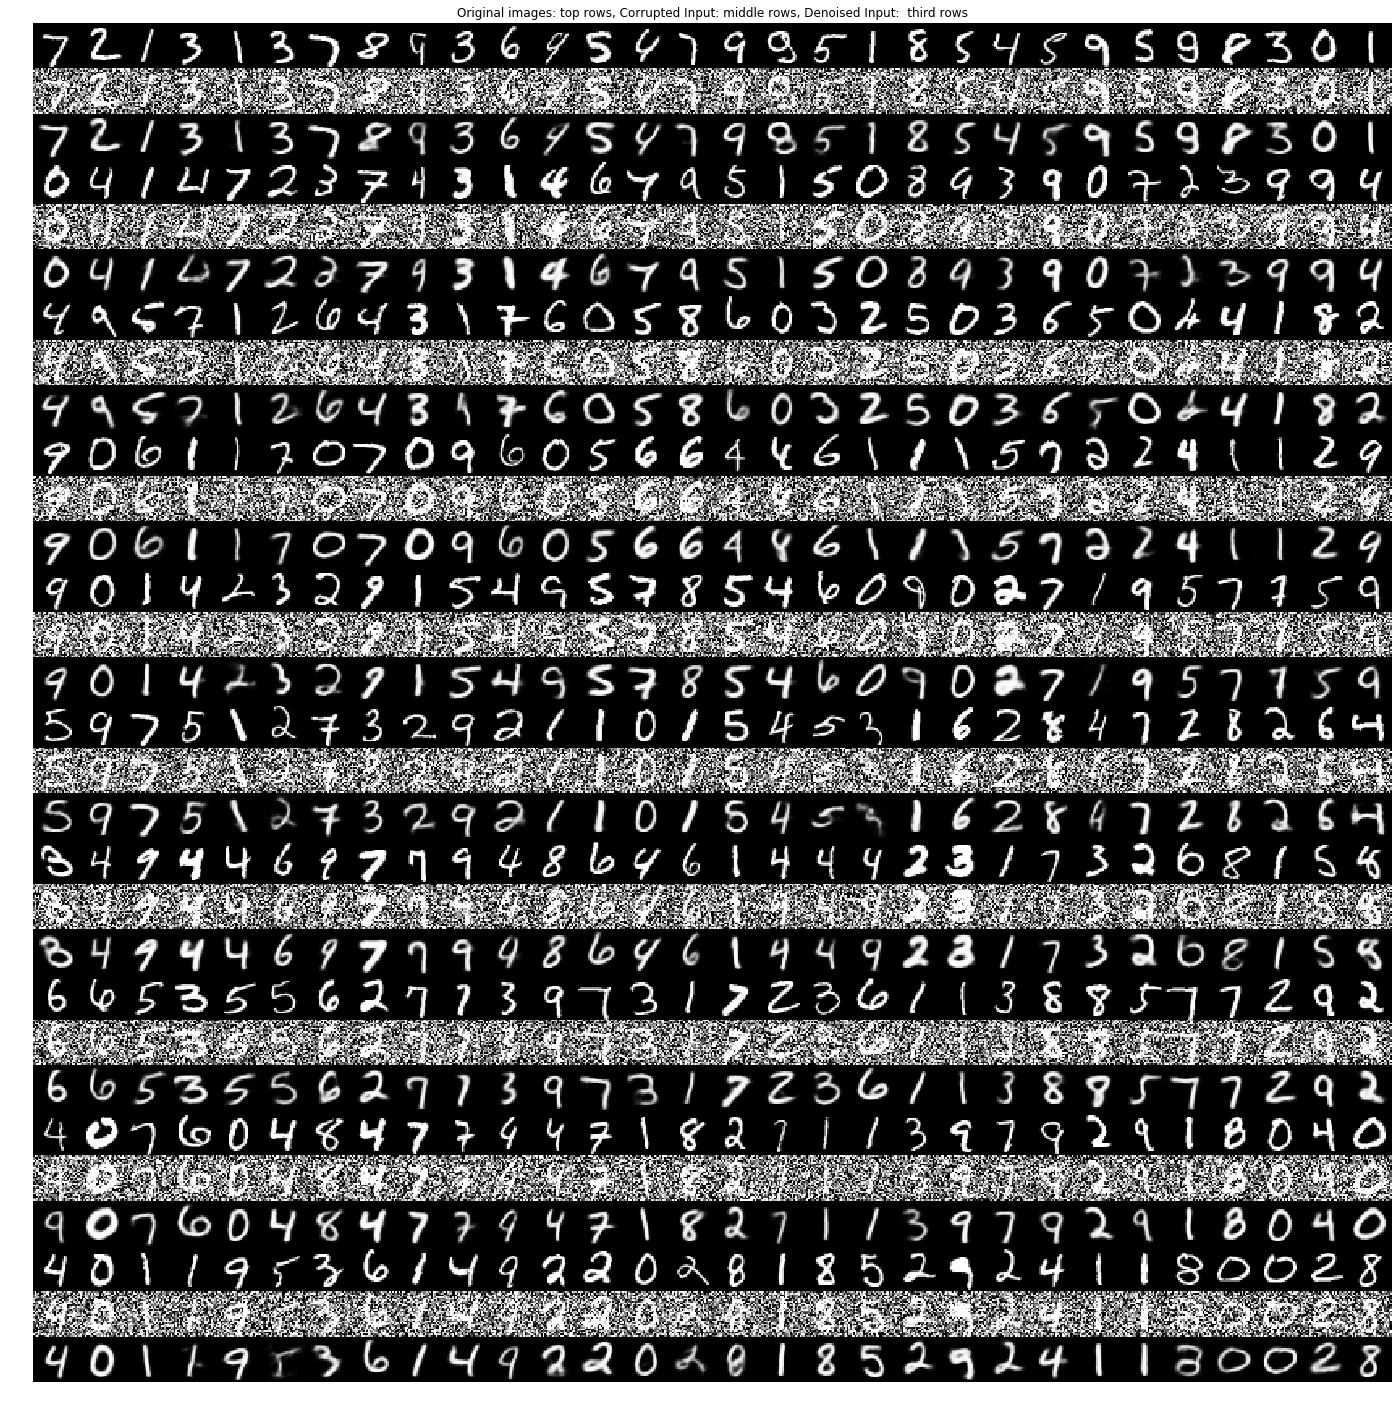

In [9]:
%matplotlib inline
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
print('Encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
print('Decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
print('Encoder-decoder apliado para entrenamiento')
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.rcParams['figure.figsize'] = [25, 25]
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

## Visualizando los resultado

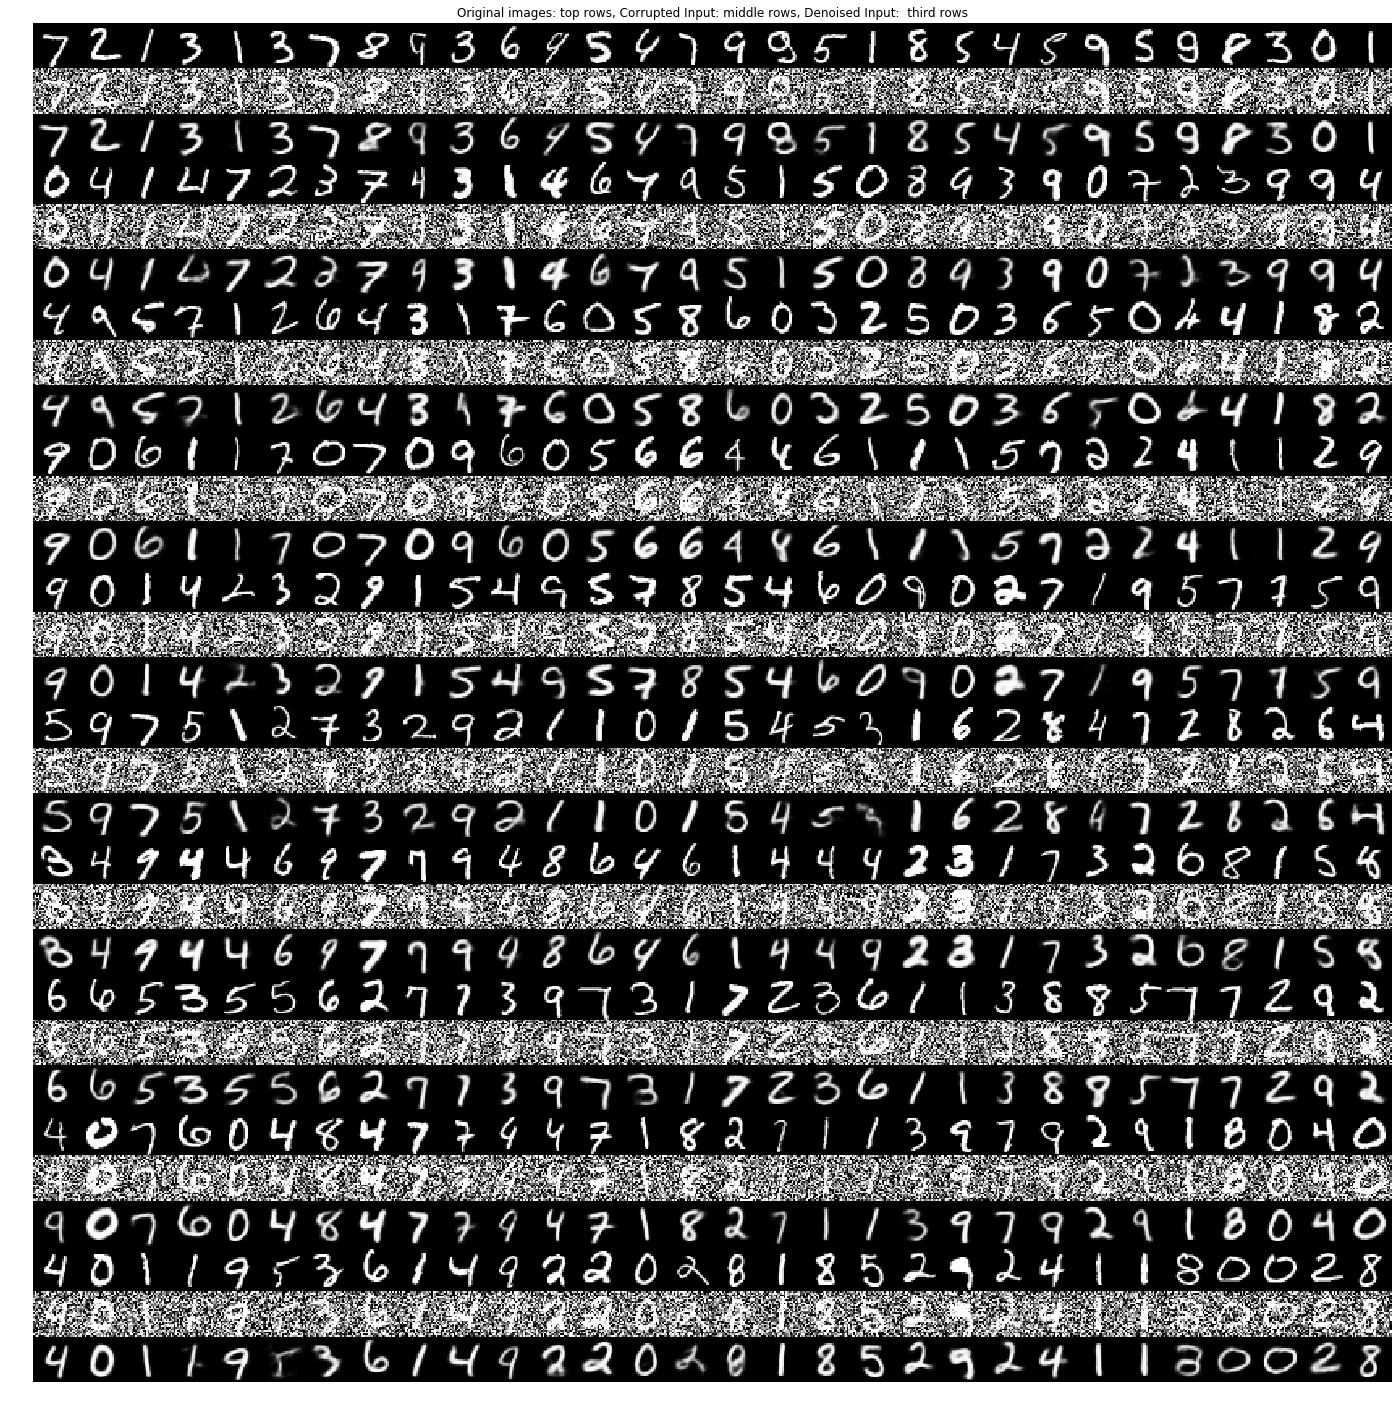

In [10]:
plt.rcParams['figure.figsize'] = [25, 25]
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

## Variational autoencoder

Los variational autoencoders son considerados modelos generativos, es decir, que se pueden construir nuevas intancias utilizando este modelo. Al igual que el autoencoder presentado anteriormente, reduce la representación a un espacio dimensional menor. Sin embargo, este espacio representan poblaciones de distribución normal representado por su media y varianza (generalmente se utiliza el logaritmo de la varianza). Por este motivo, a la hora de reconstruir el decoder deber realizar un sampling de este espacio normal. Al ser un sampling, la reconstrucción no es deterministica por lo que se generan nuevas instancias similares a las anteriores.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_7[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_7[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

60000/60000 [==============================] - 5s 75us/step - loss: 146.3898 - val_loss: 149.9892
Epoch 48/50
60000/60000 [==============================] - 4s 73us/step - loss: 146.3053 - val_loss: 149.6236
Epoch 49/50
60000/60000 [==============================] - 5s 76us/step - loss: 146.2087 - val_loss: 149.6436
Epoch 50/50
60000/60000 [==============================] - 4s 75us/step - loss: 146.1024 - val_loss: 149.9529


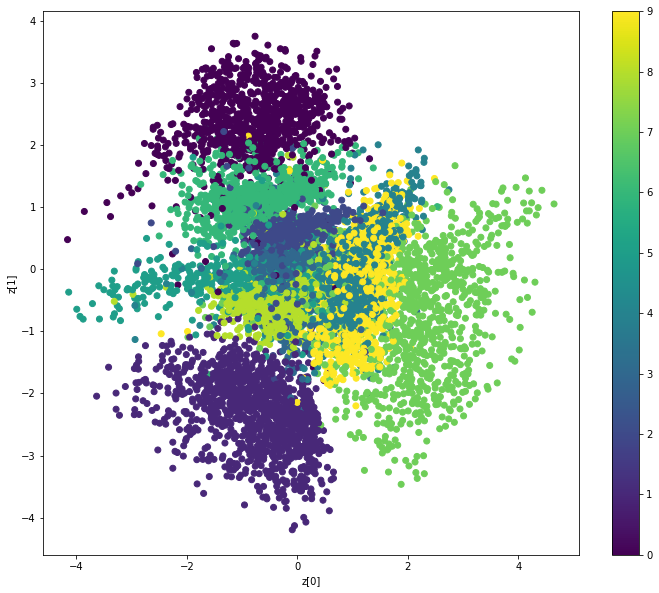

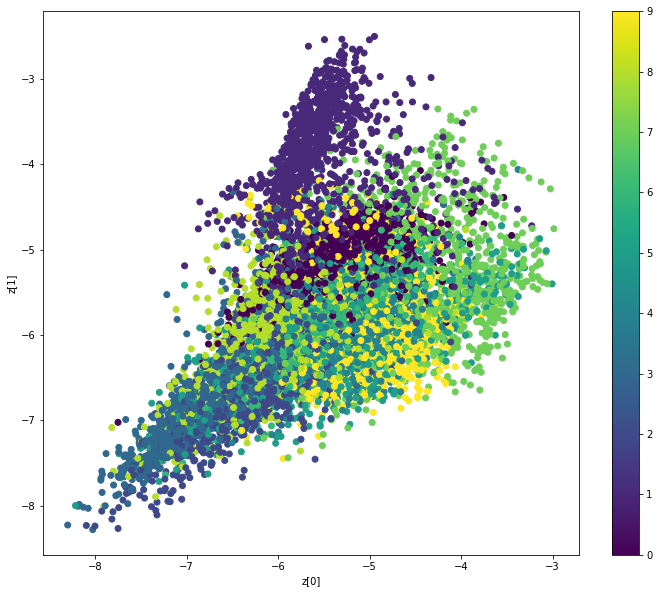

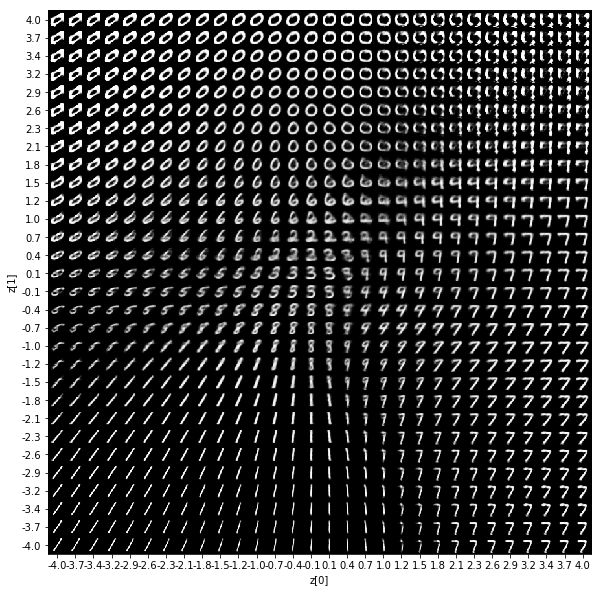

In [11]:
%matplotlib inline
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    plt.figure(figsize=(12, 10))
    plt.scatter(z_log_var[:, 0], z_log_var[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    
    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

def run():
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    #reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss = binary_crossentropy(inputs, outputs)

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    plot_model(vae,
               to_file='vae_mlp.png',
               show_shapes=True)
    
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    #vae.save_weights('vae_mlp_mnist.h5')

    plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")
    
run()